In [1]:
import pointCollection as pc
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from LSsurf import RDE

In [2]:
%matplotlib notebook

In [3]:
data_root='/Volumes/ice2/ben/openTopography/Boulder'
D_bare=pc.grid.data().from_geotif(data_root+'/snow_off/08.21.10/BcCZO_DTM_SnOff.tif')


In [4]:
# make the local geoid with:
# gdalwarp -t_srs EPSG:26913 -te 438990.0 4417990.0 481510.0 4446010.0 -tr 100 100 GEOID12B/GEOID12B.tif GEOID12B.tif
D_geoid = pc.grid.data().from_geotif(data_root+'//snow_off/08.21.10/GEOID12B.tif')

In [5]:
#! gdalinfo {data_root+'/snow_off/08.21.10/BcCZO_DTM_SnOff.tif'}
#print({data_root+'/snow_off/08.21.10/BcCZO_DTM_SnOff.tif'})

In [6]:
def interp_pts_from_DEM(D0, Dg):
    ccf=(D0.x-Dg.x[0])/(Dg.x[1]-Dg.x[0])
    rrf=(D0.y-Dg.y[0])/(Dg.x[1]-Dg.x[0])
    good=(ccf>0) & (ccf<Dg.shape[1]-2) &  (rrf>0) & (rrf<Dg.shape[0]-2)
    ccf=ccf[good]
    rrf=rrf[good]
    
    rr0=np.floor(rrf).astype(int)
    cc0=np.floor(ccf).astype(int)
    rr=np.c_[rr0, rr0+1, rr0, rr0+1]
    cc=np.c_[cc0, cc0, cc0+1, cc0+1]
    v=np.zeros(D0.shape)+np.NaN
    v[good]=np.sum(
        Dg.z.ravel()[np.ravel_multi_index([rr.ravel(), cc.ravel()], Dg.z.shape)].reshape(rr.shape)*\
        (1-np.abs(np.tile(rrf[:,None], [1, 4])-rr))*(1-np.abs(np.tile(ccf[:, None], [1, 4])-cc)),\
        axis=1)
    return v

In [7]:
SR_files={'ice':glob.glob(data_root+'/slideRule/ice/*.h5'), 'land': glob.glob(data_root+'/slideRule/land/*.h5')}

D_dict={'land':{}, 'ice':{}}
for srf_type, files in SR_files.items():
    for file in files:
        print(file)
        D0=pc.data().from_h5(file, group='/')
        D0.assign({'latitude':D0.lat,'longitude':D0.lon})

        D0.get_xy(EPSG=26913)
        D0.assign({'DEM': interp_pts_from_DEM(D0, D_bare)})
        D0.assign({'geoid': interp_pts_from_DEM(D0, D_geoid)})
        D_dict[srf_type][os.path.basename(file)]=D0


/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf2_L40.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf4_L20.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf3_L5.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf2_L20.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf3_L10.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf2_L5.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf3_L80.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf4_L40.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf3_L20.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf4_L5.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf2_L80.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/Boulder_ice_cnf2_L10.h5
/Volumes/ice2/ben/openTopography/Boulder/slideRule/ice/

In [8]:
D_dict['land'].keys()

dict_keys(['Boulder_cnf2_L40.h5', 'Boulder_cnf4_L5.h5', 'Boulder_cnf4_L20.h5', 'Boulder_cnf2_L20.h5', 'Boulder_cnf4_L40.h5', 'Boulder_cnf3_L80.h5', 'Boulder_cnf3_L10.h5', 'Boulder_cnf3_L20.h5', 'Boulder_cnf2_L10.h5', 'Boulder_cnf2_L80.h5', 'Boulder_cnf3_L5.h5', 'Boulder_cnf3_L40.h5', 'Boulder_cnf4_L80.h5', 'Boulder_cnf4_L10.h5', 'Boulder_cnf2_L5.h5'])

In [10]:
# calculate the delta_time equivalent to 5 m
dt_5 = 5/7000


# get common list of reference points:

key=list(D_dict['land'].keys())[0]
rt0=np.round(D_dict['land'][key].delta_time/dt_5)
rt0=np.unique(np.r_[rt0-1, rt0, rt0+1])
for key1 in list(D_dict['land'].keys())[1:]:
    rt1=np.round(D_dict['land'][key1].delta_time/dt_5)
    rt1=np.unique(np.r_[rt1-1, rt1, rt1+1])
    rt0=rt0[np.in1d(rt0, rt1)]

for key1 in list(D_dict['ice'].keys()):
    rt1=np.round(D_dict['ice'][key1].delta_time/dt_5)
    rt1=np.unique(np.r_[rt1-1, rt1, rt1+1])
    rt0=rt0[np.in1d(rt0, rt1)]

print(len(rt0))
    
rt0=np.unique(np.r_[rt0-1, rt0, rt0+1])
# select the points that are in common between all datasets
D_common={'land':{},'ice':{}}
for srf_type in D_common.keys():
    for key1 in D_dict[srf_type].keys():
        rt1=np.round(D_dict[srf_type][key1].delta_time/dt_5)
        D_common[srf_type][key1]=D_dict[srf_type][key1][np.in1d(rt1, rt0)]


71539


Boulder_cnf2_L5.h5 : 27619 4.67
Boulder_cnf2_L10.h5 : 34045 3.06
Boulder_cnf2_L20.h5 : 38905 2.79
Boulder_cnf2_L40.h5 : 41948 2.90
Boulder_cnf2_L80.h5 : 42655 3.10
Boulder_cnf3_L5.h5 : 22229 3.49
Boulder_cnf3_L10.h5 : 27715 2.49
Boulder_cnf3_L20.h5 : 32498 2.37
Boulder_cnf3_L40.h5 : 35834 2.52
Boulder_cnf3_L80.h5 : 37062 2.76
Boulder_cnf4_L5.h5 : 19587 3.43
Boulder_cnf4_L10.h5 : 24492 2.41
Boulder_cnf4_L20.h5 : 28723 2.28
Boulder_cnf4_L40.h5 : 31803 2.42
Boulder_cnf4_L80.h5 : 33054 2.65
Boulder_ice_cnf2_L5.h5 : 26761 4.01
Boulder_ice_cnf2_L10.h5 : 33096 2.83
Boulder_ice_cnf2_L20.h5 : 37614 2.61
Boulder_ice_cnf2_L40.h5 : 40532 2.70
Boulder_ice_cnf2_L80.h5 : 41217 2.90
Boulder_ice_cnf3_L5.h5 : 22513 3.28
Boulder_ice_cnf3_L10.h5 : 28238 2.43
Boulder_ice_cnf3_L20.h5 : 32926 2.34
Boulder_ice_cnf3_L40.h5 : 36300 2.50
Boulder_ice_cnf3_L80.h5 : 37644 2.75
Boulder_ice_cnf4_L5.h5 : 20234 3.12
Boulder_ice_cnf4_L10.h5 : 25123 2.31
Boulder_ice_cnf4_L20.h5 : 29361 2.22
Boulder_ice_cnf4_L40.h5 : 3258

<IPython.core.display.Javascript object>


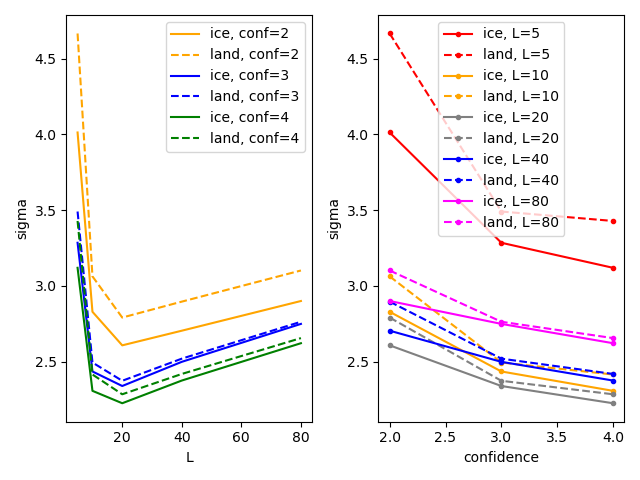

In [14]:
sigma={srf_type:np.zeros((3, 5)) for srf_type in D_common.keys()}
bar={srf_type:np.zeros((3, 5)) for srf_type in D_common.keys()}
N={srf_type:np.zeros((3, 5)) for srf_type in D_common.keys()}
L_vals=[5, 10, 20, 40 , 80]
c_vals=[2, 3, 4]
for srf_type in D_common.keys():
    for ic, cnf in enumerate(c_vals):
        for iL, L in enumerate(L_vals):
            if srf_type=='ice':
                thefile = f"Boulder_ice_cnf{cnf}_L{L}.h5"
            else:
                thefile = f"Boulder_cnf{cnf}_L{L}.h5"
            D0=D_common[srf_type][thefile]
            sigma[srf_type][ic, iL]  = RDE(D0.h_mean-D0.DEM)
            bar[srf_type][ic, iL] = np.nanmedian(D0.h_mean-(D0.DEM+D0.geoid))
            N[srf_type][ic, iL] = np.sum(np.isfinite(D0.h_mean-D0.DEM))
            print(f"{thefile} : {np.sum(np.isfinite(D0.h_mean-D0.DEM))} {RDE(D0.h_mean-D0.DEM):2.2f}")

c_colors={2:'orange', 3:'blue',4:'green'}
L_colors={5:'red', 10:'orange', 20:'gray', 40:'blue', 80:'magenta'}
styles={'ice':'-','land':'--'}
hfig=plt.figure()
hax=hfig.subplots(1,2)

plt.sca(hax[0]);
for ic, cnf in enumerate(c_vals):
    for srf_type in styles:
        plt.plot(L_vals, sigma[srf_type][ic,:], linestyle=styles[srf_type], label=f'{srf_type}, conf={cnf}', color=c_colors[cnf])
plt.legend()
plt.gca().set_xlabel('L')
plt.gca().set_ylabel('sigma')

plt.sca(hax[1]); 
for iL, L in enumerate(L_vals):
    for srf_type in styles:
        plt.plot(c_vals, sigma[srf_type][:,iL],  linestyle=styles[srf_type], label=f'{srf_type}, L={L}', color=L_colors[L], marker='.')
plt.legend()
plt.gca().set_xlabel('confidence')
plt.gca().set_ylabel('sigma')
plt.tight_layout()

<IPython.core.display.Javascript object>


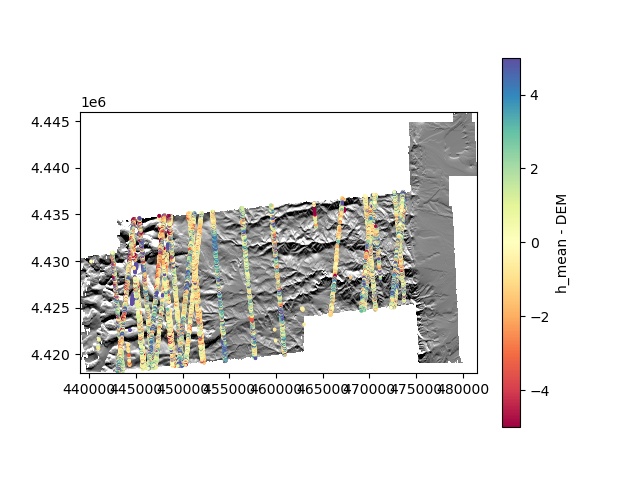

In [19]:
plt.figure(); 

cnf=4
L=20
thefile = f"Boulder_cnf{cnf}_L{L}.h5"
D0=D_dict['land'][thefile]
D_bare.show(cmap='gray', gradient=True)
h_map=plt.scatter(D0.x, D0.y, 2, c=D0.h_mean-(D0.DEM+D0.geoid), vmin=-5, vmax=5, cmap='Spectral')
plt.colorbar(mappable=h_map, label='h_mean - DEM')

In [20]:
XR=np.r_[plt.gca().get_xlim()]
YR=np.r_[plt.gca().get_ylim()]
XR=np.round(XR/1.e3)*1.e3
YR=np.round(YR/1.e3)*1.e3

#XR, YR=[np.round(ii) for ii in D_bare.bounds()]

print(f"-tr {XR[0]} {YR[1]} {XR[1]} {YR[0]}")

-tr 446000.0 4429000.0 446000.0 4428000.0


In [21]:
print(f"-te {XR[0]} {YR[0]} {XR[1]} {YR[1]}")

-te 446000.0 4428000.0 446000.0 4429000.0
